In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.6 MB/s eta 0:00:00


In [3]:
!pip install torch torchvision

In [4]:
from transformers import AutoTokenizer, AutoModel

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/SC

/content/drive/MyDrive/SC


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv('/content/drive/MyDrive/SC/train.csv')

In [8]:
print ("total rows: ", len(df))

total rows:  20972


In [9]:
df.isnull().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

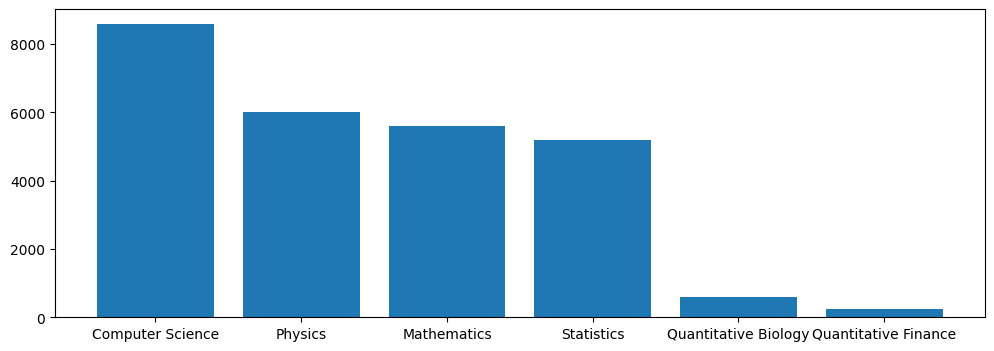

In [10]:
df_classes = df.drop(['ID', 'TITLE', 'ABSTRACT'], axis=1)

column_names = df_classes.columns
X_axis = range(len(column_names))

plt.figure(figsize=(12, 4))
plt.bar(X_axis, df.drop(['ID', 'TITLE', 'ABSTRACT'], axis=1).sum())
plt.xticks(X_axis, column_names)

plt.show()

In [ ]:
torch.manual_seed(42)

In [11]:
tokenizer = tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")

max_title_length = 20
max_abstract_length = 300

def tokenize(data, max_length):
    x = str(data)
    tokens = tokenizer.encode_plus(data,
                                   max_length=max_length,
                                   padding="max_length",
                                   truncation=True,
                                   return_tensors="pt")
    return tokens["input_ids"].squeeze(), tokens["attention_mask"].squeeze()

In [12]:
class CustomDataset(Dataset):
    def __init__(self, data_frame, is_test=False):
        self.titles = data_frame["TITLE"].tolist()
        self.abstracts = data_frame["ABSTRACT"].tolist()
        self.is_test = is_test
        if not self.is_test:
            self.labels = data_frame.drop(["ID", "TITLE", "ABSTRACT"], axis=1).values.astype(np.float32)

    def __getitem__(self, index):
        title_input_ids, title_attention_mask = tokenize(self.titles[index], max_title_length)
        abstract_input_ids, abstract_attention_mask = tokenize(self.abstracts[index], max_abstract_length)
        if self.is_test:
            return title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask
        else:
            label = torch.tensor(self.labels[index])
            return title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask, label

    def __len__(self):
        return len(self.titles)

In [13]:
total_rows = len(df)
df = shuffle(df)
train_size = int(total_rows * 0.8)
valid_size = int(total_rows * 0.1)

df_train = df[:train_size]
df_valid = df[train_size:train_size+valid_size]
df_test = df[train_size+valid_size:]

train_dataset = CustomDataset(df_train)
valid_dataset = CustomDataset(df_valid)
test_dataset = CustomDataset(df_test)

In [14]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [15]:
augmented_data = []

for index, label in enumerate(train_dataset.labels):
    if label[4] == 1 or label[5] == 1:
        augmented_data.append(train_dataset[index])
        augmented_data.append(train_dataset[index])

train_loader_augmented = DataLoader(augmented_data, batch_size=batch_size, shuffle=True)
train_loader = torch.utils.data.ConcatDataset([train_dataset, augmented_data])
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)

In [16]:
bert = model_roberta = AutoModel.from_pretrained("roberta-base")
bert.to(device)
bert.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [17]:
class Model(nn.Module):
    def __init__(self, bert_model):
        super(Model, self).__init__()
        self.bert = bert_model
        self.title_emb = nn.Sequential(
            nn.Linear(bert_model.config.hidden_size, 512),
            nn.ReLU()
        )
        self.abstract_emb = nn.Sequential(
            nn.Linear(bert_model.config.hidden_size, 512),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
        )


    def forward(self, title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask):

      title_output = self.bert(input_ids=title_input_ids, attention_mask=title_attention_mask)[0]
      title_emb = torch.mean(title_output, dim=1)
      title_emb = self.title_emb(title_emb)

      abstract_output = self.bert(input_ids=abstract_input_ids, attention_mask=abstract_attention_mask)[0]
      abstract_emb = torch.mean(abstract_output, dim=1)
      abstract_emb = self.abstract_emb(abstract_emb)

      x = torch.cat((title_emb, abstract_emb), dim=-1)
      x = self.mlp(x)
      output = x.unsqueeze(dim=-1)
      return output

In [18]:
model = Model(bert)
model.to(device)

Model(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [19]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCEWithLogitsLoss()

In [20]:
num_epochs = 5
best_valid_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask, labels = batch
        title_input_ids = title_input_ids.to(device)
        title_attention_mask = title_attention_mask.to(device)
        abstract_input_ids = abstract_input_ids.to(device)
        abstract_attention_mask = abstract_attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask)
        loss = criterion(outputs, labels.unsqueeze(dim=-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_size

    train_loss /= len(train_loader)

    model.eval()
    valid_loss = 0.0
    preds = []
    true_labels = []

    with torch.no_grad():
        for batch in valid_loader:
            title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask, labels = batch
            title_input_ids = title_input_ids.to(device)
            title_attention_mask = title_attention_mask.to(device)
            abstract_input_ids = abstract_input_ids.to(device)
            abstract_attention_mask = abstract_attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask)
            loss = criterion(outputs, labels.unsqueeze(dim=-1))
            valid_loss += loss.item() * batch_size

            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        valid_loss /= len(valid_loader)
        preds = np.array(preds)
        true_labels = np.array(true_labels)

        preds[preds >= 0.5] = 1.0
        preds[preds < 0.5] = 0.0

        acc_scores = []
        f1_scores = []

        for i in range(true_labels.shape[1]):
            true_labels_i = true_labels[:, i]
            preds_i = preds[:, i]

            acc = accuracy_score(true_labels_i, preds_i)
            f1 = f1_score(true_labels_i, preds_i, average="binary")

            acc_scores.append(acc)
            f1_scores.append(f1)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} , Valid Loss: {valid_loss:.4f}")
    print("Accuracy Scores:", acc_scores)
    print("F1 Scores:", f1_scores)

Epoch 1/5
Train Loss: 13.4101 , Valid Loss: 7.3538
Accuracy Scores: [0.8536003814973772, 0.9208392942298522, 0.9084406294706724, 0.8373867429661421, 0.9723414401525989, 0.9909394372913686]
F1 Scores: [0.8274311410905003, 0.8477064220183487, 0.8160919540229885, 0.6773888363292337, 0.0, 0.0]
Epoch 2/5
Train Loss: 7.0235 , Valid Loss: 6.3125
Accuracy Scores: [0.848831664282308, 0.9294229852169766, 0.916070577014783, 0.8664759179780639, 0.9570815450643777, 0.9909394372913686]
F1 Scores: [0.8120924718435092, 0.8692579505300354, 0.8317399617590823, 0.7183098591549296, 0.48863636363636365, 0.0]
Epoch 3/5
Train Loss: 5.6791 , Valid Loss: 5.8562
Accuracy Scores: [0.876967095851216, 0.9346685741535526, 0.9089175011921793, 0.8845970433953266, 0.9713876967095851, 0.994277539341917]
F1 Scores: [0.8611410118406888, 0.8786536758193092, 0.8084252758274825, 0.7494824016563146, 0.5161290322580646, 0.7]
Epoch 4/5
Train Loss: 4.8954 , Valid Loss: 5.7661
Accuracy Scores: [0.8731521220791607, 0.932284215546

In [21]:
model.eval()
test_loss = 0.0
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask, labels = batch
        title_input_ids = title_input_ids.to(device)
        title_attention_mask = title_attention_mask.to(device)
        abstract_input_ids = abstract_input_ids.to(device)
        abstract_attention_mask = abstract_attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask)
        loss = criterion(outputs, labels.unsqueeze(dim=-1))
        test_loss += loss.item() * batch_size

        preds.extend(torch.sigmoid(outputs).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    preds = np.array(preds)
    true_labels = np.array(true_labels)

    preds[preds >= 0.5] = 1.0
    preds[preds < 0.5] = 0.0

    acc_scores = []
    f1_scores = []

    for i in range(true_labels.shape[1]):
        true_labels_i = true_labels[:, i]
        preds_i = preds[:, i]

        acc = accuracy_score(true_labels_i, preds_i)
        f1 = f1_score(true_labels_i, preds_i, average="binary")

        acc_scores.append(acc)
        f1_scores.append(f1)

print(f"Test Loss: {test_loss:.4f}")
print("Accuracy Scores:", acc_scores)
print("F1 Scores:", f1_scores)

Test Loss: 5.9253
Accuracy Scores: [0.8612964728312679, 0.9437559580552908, 0.9051477597712106, 0.880838894184938, 0.9809342230695901, 0.990467111534795]
F1 Scores: [0.830122591943958, 0.8964912280701754, 0.8192552225249774, 0.7735507246376813, 0.6078431372549019, 0.5]


In [22]:
X_axis = np.arange(len(column_names))

plt.figure(figsize=(12, 6))
plt.bar(X_axis-0.2, acc_scores, width=0.4, label='acc')
plt.bar(X_axis+0.2, f1_scores, width=0.4, label='f1')

plt.xticks(X_axis, column_names)
plt.ylabel('prediction score')
plt.legend()
plt.show()

In [23]:
torch.save(model.state_dict(), "model_roberta.pth")

In [24]:
model = Model(bert)
model.load_state_dict(torch.load("model_roberta.pth"))
model.eval()

Model(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)